In [1]:
# USAGE
# python train.py

In [11]:
# import the necessary packages
from dataset import Dataset
from model import UNet
import segmentation_models_pytorch as smp
import config 

from torch.nn import CrossEntropyLoss 
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import os

In [3]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(config.MASK_DATASET_PATH)))

# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths, test_size=config.TEST_SPLIT, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(config.TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [4]:
# create the train and test datasets
trainDS = Dataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = Dataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True, 
                         batch_size=config.BATCH_SIZE, 
                         pin_memory=config.PIN_MEMORY, 
                         num_workers=os.cpu_count())

testLoader = DataLoader(testDS, shuffle=False, 
                        batch_size=config.BATCH_SIZE, 
                        pin_memory=config.PIN_MEMORY, 
                        num_workers=os.cpu_count())

[INFO] found 1079 examples in the training set...
[INFO] found 191 examples in the test set...


In [18]:
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,      
    classes=256
)

#model = models.resnet18(pretrained=True)

In [19]:
# initialize our UNet model
#unet = UNet().to(config.DEVICE)
unet = model.to(config.DEVICE)

# initialize loss function and optimizer
#lossFunc = lambda x, y: CrossEntropyLoss()(x.reshape(-1, 256), y.reshape(-1))
#lossFunc = smp.utils.losses.DiceLoss()
lossFunc = CrossEntropyLoss()

opt = Adam(unet.parameters(), lr=config.INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // config.BATCH_SIZE
testSteps = len(testDS) // config.BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [20]:
# loop over epochs

unnormalize = transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1/0.229, 1/0.224, 1/0.225])

print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
    # set the model in training mode
    unet.train()

    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
        
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)
        
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()

        # add the loss to the total training loss so far
        totalTrainLoss += loss.item()
    
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        
        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
            
            
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y).item()
            
            fig, ax = plt.subplots(ncols=3)
            ax[0].imshow(unnormalize(x[0]).cpu().detach().permute(1, 2, 0))
            ax[1].imshow(y[0].cpu(), cmap = "tab20", vmin=0, vmax=255)
            ax[2].imshow(torch.argmax(pred[0],dim=0).cpu(), cmap = "tab20", vmin=0, vmax=255)
            plt.show()
            
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    
    # update our training history
    H["train_loss"].append(avgTrainLoss)
    H["test_loss"].append(avgTestLoss)
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
    
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  0%|                                                                      | 0/40 [00:20<?, ?it/s]


KeyboardInterrupt: 

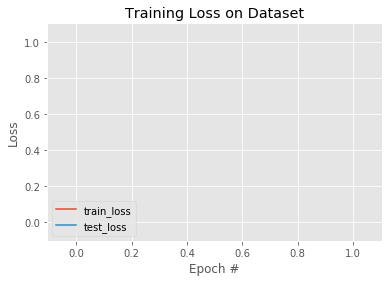

In [21]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)

# serialize the model to disk
torch.save(unet, config.MODEL_PATH)